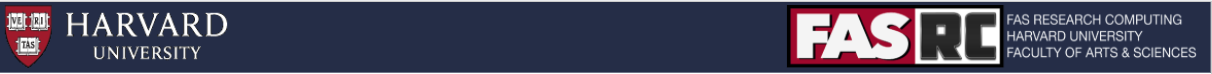
# Build You a NumPy: From Dot-Products to Machine Code

## Anand Srinivasan

04/05/2022

FASRC Training Course

In [1]:
%matplotlib notebook

In [2]:
import perfplot
import kuramoto as km
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

## Numerics 101: start with a PDE

Numerical optimization is best approached with a concrete problem. We will start with a 2-dimensional lattice variant of the [Kuramoto model](https://en.wikipedia.org/wiki/Kuramoto_model), a simple protoypical model of synchronization in multi-oscillator systems.

Classically, it was formulated as the system of ordinary differential equations:

$$
\frac{d\theta_i}{dt} = \omega_i + \frac{K}{N}\sum_{j=1}^N\sin(\theta_j - \theta_i)
$$

where $\theta_i$ is the phase of oscillator $i$ and $\omega_i$ is its _intrinsic frequency_.

This is a fully-connected model, and for visualization purposes we we will turn this into a two-dimensional PDE as follows. First, we consider $\theta_j \sim \theta_i$ only if $j, i$ are "nearest-neighbors" on a two-dimensional lattice. Then, we will take the lattice spacing $\epsilon \to 0$, in which case $\theta_j - \theta_i$ becomes the gradient $\nabla \theta(x, y)$. Finally, the outer sum becomes a divergence operator, giving us:

$$
\frac{\partial \theta}{\partial t} = \omega + K\nabla \cdot \sin(\nabla \theta)
$$

where $\theta(x, y)$ and $\omega(x, y)$ are now fields which we define on the unit square $[0, 1] \times [0, 1]$. In addition, we'll impose the _zero-flux_ boundary conditions:

$$
\frac{\partial \theta}{\partial x}(0, y) = \frac{\partial \theta}{\partial x}(1, y) = \frac{\partial \theta}{\partial y}(x, 0) = \frac{\partial \theta}{\partial y}(x, 1) = 0
$$

which just means that the difference $\theta_j - \theta_i$ is zero at the boundary, so the system is "insulated".

This looks like a diffusion equation (the $\nabla \cdot \nabla$), but the $\sin(\cdot)$ nonlinearity makes it impossible to express the operator $\nabla \cdot \sin \circ \nabla$ as a matrix. Surprisingly, this equation has an exact solution, but we're going to solve it numerically.

## Starting with a naive implementation

In [src/kuramoto/base.py](src/kuramoto/base.py), you'll find the `KuramotoSolver` class which implements most of the basic functionality we need:
* parameters (size of grid $N \times N$; coupling constant $K$)
* time-stepping (we will use Euler's method for simplicity with fixed $\Delta t$)

Our goal is to implement the right-hand side of $\frac{\partial \theta}{\partial t}$. Let's start with a naive implementation:

In [3]:
class NaiveSolver(km.KuramotoSolver):

    def dudt(self, u: npt.NDArray) -> npt.NDArray:
        ''' Centered-difference gradient with zero Neumann condition '''
        
        dudt = self.omega.copy()

        for row in range(self.N):
            for col in range(self.N):

                # Horizontal neighbors
                if row > 0:
                    dudt[row, col] += self.K * np.sin(u[row-1, col] - u[row, col])
                if row < self.N-1:
                    dudt[row, col] += self.K * np.sin(u[row+1, col] - u[row, col])

                # Vertical neighbors
                if col > 0:
                    dudt[row, col] += self.K * np.sin(u[row, col-1] - u[row, col])
                if col < self.N-1:
                    dudt[row, col] += self.K * np.sin(u[row, col+1] - u[row, col])

        return dudt

This is the simplest implementation we can imagine. Now let's visualize it!

Using dtype: <class 'numpy.float64'>
Solving...
Finished.


<IPython.core.display.Javascript object>


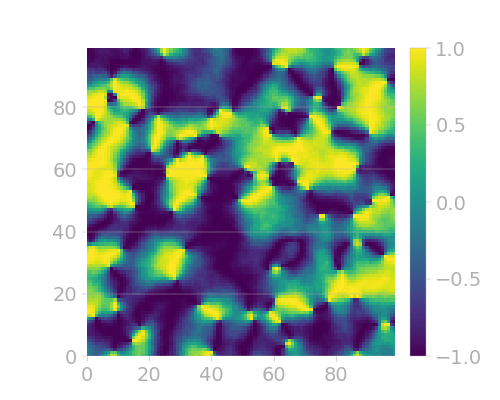

In [4]:
solver = NaiveSolver(N=100, T=10, K=2.0, record=True)
solver.integrate()
anim = solver.play_video()

Pro-tip: to turn the sequence of solutions into a video, we use [matplotlib's FuncAnimation](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.animation.FuncAnimation.html).

## Benchmarking the naive solution
That took a few seconds (or more, depending on your machine). Not bad, but in realistic settings we might want to run with $N$ or $T$ very large. Let's see where time and memory are spent so we can think about optimizing it. 

### Time 
To profile time line-by-line, we'll use the excellent [line_profiler](https://github.com/pyutils/line_profiler) library. This can either be used as a decorator:
```python
@profile
def my_expensive_func():
    do_something_real_difficult()
```
and then use the command-line utility `kernprof` to produce and visualize the benchmark:
```bash
kernprof -l script.py
python -m line_profiler script.py.lprof
```
However, we would like to avoid using the `kernprof` command and run our script natively (for benchmarking memory, hardware events, etc.). Thus, `KuramotoSolver` includes a profile implementation as part of the class:

```python
import line_profiler
import atexit

# Import C++ shared object file -- this will appear in this directory at build-time
# import kuramoto._cpp

@dataclass
class KuramotoSolver:
	...
	profile: bool = False 				# Whether to run the line-profiler


	def __post_init__(self):
		...
		if self.profile:
			print('Running profiler.')
			pf = line_profiler.LineProfiler()
			self.dudt = pf(self.dudt)    # Run the profiler on our implementation
			atexit.register(pf.print_stats)
   ...
```

This is automatically invoked on any subclasses too, like `NaiveSolver`. So let's pass the `profile` flag:

In [5]:
solver = NaiveSolver(N=100, T=10, K=2.0, profile=True)
solver.integrate()

Using dtype: <class 'numpy.float64'>
Running profiler.
Solving...
Finished.
Timer unit: 1e-06 s

Total time: 11.1433 s
File: /tmp/ipykernel_56425/2848623984.py
Function: dudt at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                               def dudt(self, u: npt.NDArray) -> npt.NDArray:
     4                                                   ''' Centered-difference gradient with zero Neumann condition '''
     5                                                   
     6       101        880.0      8.7      0.0          dudt = self.omega.copy()
     7                                           
     8     10201       3430.0      0.3      0.0          for row in range(self.N):
     9   1020100     390917.0      0.4      3.5              for col in range(self.N):
    10                                           
    11                                                           # Horizontal neighbors
    12   1010000     362023.0  

This gives us a line-by-line printout of total time spent in `self.dudt` (computing the vector field). Time here is measured in microseconds. 

Immediately, we can see that most of the time is spend in adding the contributions of nearest-neighbors, lines 13, 15, 19, and 21. What can we do to improve the performance?

Here we have two nested for-loops, running inside a third one which performs the time-stepping. You may have heard that "for-loops in Python are slow." This is certainly an over-generalization, but let's follow this intuition and implement our solver using NumPy operations.

## Writing a solution in NumPy

The heuristic for writing fast code in NumPy is _vectorization_. That is, express your operations in terms of NumPy functions (which themselves contain loops in C -- except for [SIMD](https://en.wikipedia.org/wiki/Single_instruction,_multiple_data), everything ultimately becomes loops), instead of writing your loops manually. 

Here's what a simple but effective NumPy version of the above looks like:

In [6]:
class NumpySolver(km.KuramotoSolver):

    def dudt(self, u: npt.NDArray) -> npt.NDArray:
        dudt = self.omega.copy()
        
        # Horizontal gradient in the direction of +infinity
        dudx_right = u[:, 1:] - u[:, :-1]
        
        # Vertical gradient in the direction of -infinity
        dudy_down = u[1:, :] - u[:-1, :]

        # Apply contribution from horizontal neighbors
        dudt[:, :-1] += self.K * np.sin(dudx_right)
        dudt[:, 1:] += self.K * np.sin(-dudx_right)

        # Apply contribution from vertical neighbors
        dudt[:-1, :] += self.K * np.sin(dudy_down)
        dudt[1:, :] += self.K * np.sin(-dudy_down)

        return dudt

Let's unpack this operation. 

1. First, we compute two intermediate arrays, which give us the finite-differences between any node and its _right neighbors_ (`dudx_right`), as well as any node and its _below neighbors_ (`dudy_down`). If you have numerically solved PDEs before, you may recognize the indexing as a simple kind of _stencil_.

2. Next, note that, by not computing any differences at the boundaries, we are _implicitly_ enforcing the zero-flux condition. (This is also why we chose that boundary condition).

3. Finally, we make use of the fact that the gradient is _symmetric_. That is, the differences between any nodes and their right neighbors is also the negative of the differences between any nodes and their left neighbors, shifted one element to the right. This is why we only need to compute two gradient matrices (for two spatial dimensions).

Once we have this vectorized gradient, the remaining operations look identical to the naive solver, except now we have no need for for-loops, since NumPy will _broadcast_ $\sin(\cdot)$ over the matrices. This is because `np.sin` is what is referred to as a [ufunc](https://numpy.org/doc/stable/reference/ufuncs.html), or an automatically vectorizable function. One can define custom `ufunc`s in this manner.

Now, let's benchmark the NumPy implementation.

In [7]:
solver = NumpySolver(N=100, T=10, K=2.0, profile=True)
solver.integrate()

Using dtype: <class 'numpy.float64'>
Running profiler.
Solving...
Finished.
Timer unit: 1e-06 s

Total time: 0.075728 s
File: /tmp/ipykernel_56425/1312998327.py
Function: dudt at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                               def dudt(self, u: npt.NDArray) -> npt.NDArray:
     4       101        641.0      6.3      0.8          dudt = self.omega.copy()
     5                                                   
     6                                                   # Horizontal gradient in the direction of +infinity
     7       101       1824.0     18.1      2.4          dudx_right = u[:, 1:] - u[:, :-1]
     8                                                   
     9                                                   # Vertical gradient in the direction of -infinity
    10       101        551.0      5.5      0.7          dudy_down = u[1:, :] - u[:-1, :]
    11                                           
    1

The time cost goes from ~5 seconds to ~0.3 seconds -- a more than 100x speedup! If you take nothing else away from this tutorial, try to express your math in a vectorized form whenever possible. This may involve slightly difficult indexing (as we saw above), but you will see dramatic gains. NumPy is _fast_. 

Note that the time savings per-computation are _linear_ in time, but _quadratic_ in the size ($N$) of the problem. This means we can solve much larger problems easily:

Using dtype: <class 'numpy.float64'>
Solving...
Finished.


<IPython.core.display.Javascript object>


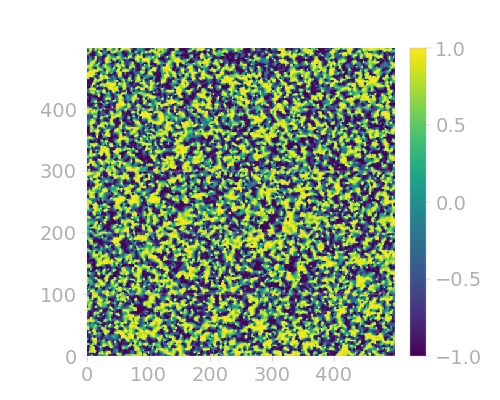

In [8]:
solver = NumpySolver(N=500, T=10, K=2.0, record=True)
solver.integrate()
solver.play_video()

Now, suppose we need to get things even faster. (PI says I need to run a 10,000 x 10,000 simulation by tomorrow.) That means we're going to take on the difficult task of beating NumPy -- but in order to do so, we have to understand why the NumPy implementation is faster. 

Again, remember that the two implementations are functionally identical -- both _abstractly_ perform the same mathematical operations. In fact, the NumPy implementation constructs two additional intermediate arrays.

Quiz: how many loops are in this code?
```python
# Horizontal gradient in the direction of +infinity
dudx_right = u[:, 1:] - u[:, :-1]

# Vertical gradient in the direction of -infinity
dudy_down = u[1:, :] - u[:-1, :]

# Apply contribution from horizontal neighbors
dudt[:, :-1] += self.K * np.sin(dudx_right)
dudt[:, 1:] += self.K * np.sin(-dudx_right)

# Apply contribution from vertical neighbors
dudt[:-1, :] += self.K * np.sin(dudy_down)
dudt[1:, :] += self.K * np.sin(-dudy_down)
```
We'll come back to this later.

## Optimization 0: Data locality

It may seem like the following two are the same:
```python
x = np.zeros(10)

# For-loop version
for i in range(10):
    x[i] = 1
    
# Numpy version
x[:] = 1
```
But they're not. In fact, we can time it:

In [9]:
N = 1000
x = np.zeros(N)

def set_ones(x):
    for i in range(N):
        x[i] = 1
        
%timeit set_ones(x)
%timeit x[:] = 1

80 µs ± 760 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
654 ns ± 4.33 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


The reason why has to do with the way Python interprets these two statements, and something called the CPU cache:

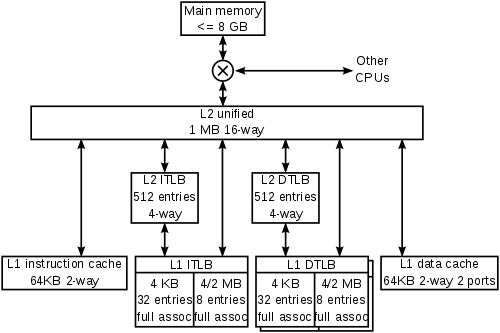
[Wikipedia](https://en.wikipedia.org/wiki/CPU_cache)

All modern processors (even Apple M1) do not have direct access to the entire region of memory in your computer. Rather, data is stored in a hierarchy of increasingly large caches (typically, L1, L2, and main memory). Any data which is not in one of these caches when requested by an instruction results in a _cache miss_, in which case the missing data must be fetched from a lower-level cache or the main memory. Moving all this data around costs time.

This brings us back to why dynamic languages like Python are so easy to use, but can incur costs which seem invisible. Let's see what's happening in this loop:
```python
for i in range(N):
    x[i] = 1
```
If you're familiar with Python's [duck typing](https://towardsdatascience.com/duck-typing-python-7aeac97e11f8#:~:text=Duck%20Typing%20is%20a%20term,care%20about%20whether%20it%20quacks.), you'll recognize what happens in each loop:
```python
class ndarray:
    ...
    def __setitem__(self, idx: slice, value: Any):
        ...
```
Every time we make the innocuous call `x[i]`, we have to:
1. Look up the method `__getitem__` of `ndarray` (resolving any polymorphism due to inheritance, if it exists)
2. Reference the indices inside the `slice` object which tells us how to do slicing
3. Finally, dereference the value inside of the array data itself.

Step (1) requires loading the class definition into memory, if not already. Step (2) involves the construction of another intermediate slice object. Finally, step (3) loads the actual data. What this means is that our data is laid out in memory something like this:

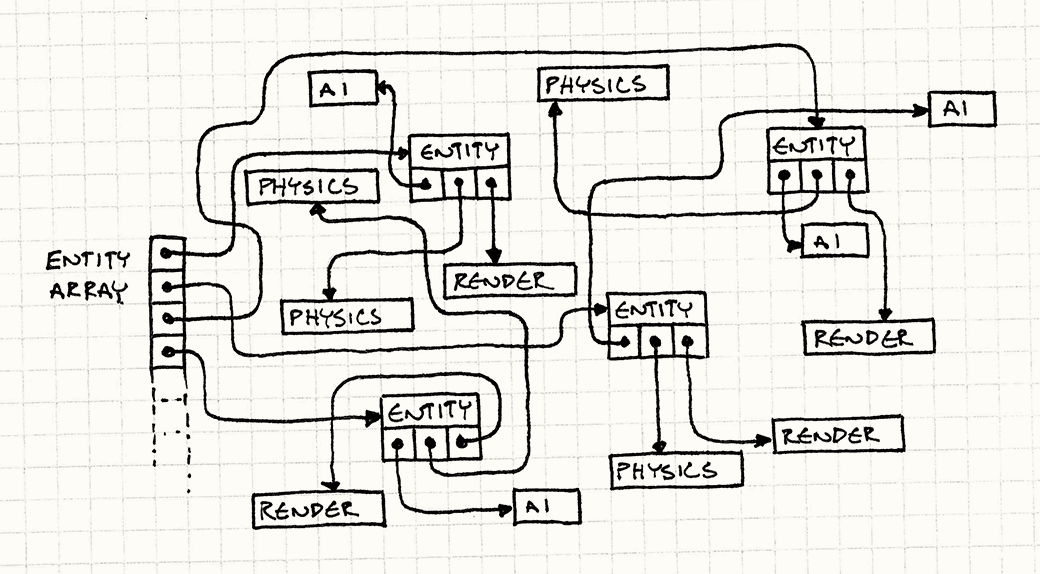

[gameprogrammingpatterns.com](https://gameprogrammingpatterns.com/data-locality.html)

Meanwhile, our L1/L2 cache is constantly loading chunks of data which are irrelevant:

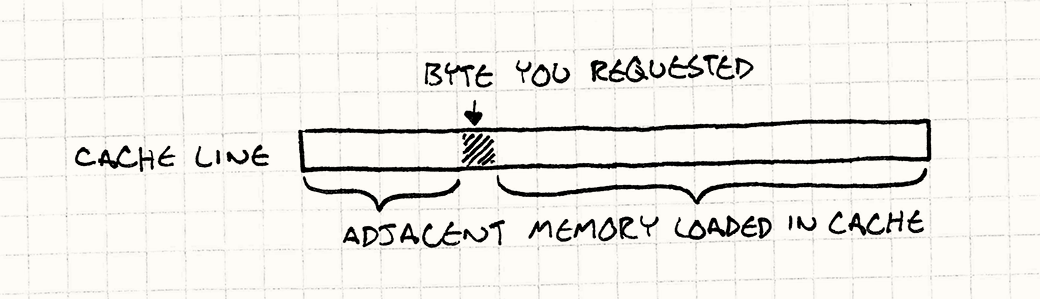

[gameprogrammingpatterns.com](https://gameprogrammingpatterns.com/data-locality.html)

On the other hand, the second approach:
```python
x[:] = 1
```
does all of the fancy Python-duck typing exactly once. We pass one `slice(None, None, None)` indicating we want the whole array to be set, and then all other data is referenced _contiguously_. The iteration is done in C on a C-style contiguous array of `int64`, and thus we incur fewer cache misses because the next referenced piece of data is _already in the cache_. 

## Anatomy of a NumPy array: contiguous vs. Non-contiguous data

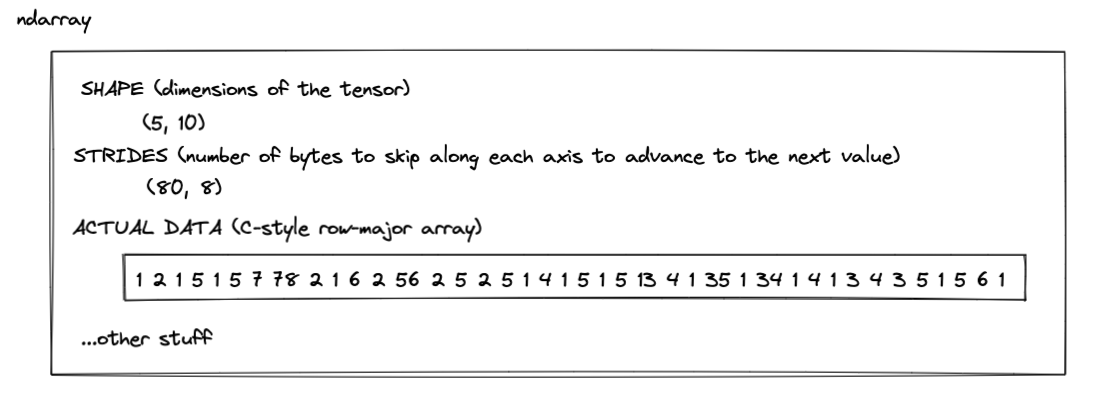

NumPy data is arranged in a _contiguous_ array. Meaning, the actual values are stored literally adjacent in memory, which means that loading data into cache in blocks results in infrequent misses if iterating _in order_. This is one of the major benefits of vectorization: moving for-loops from Python to C avoids referencing data in memory _out of order_. This optimization is known as _data locality_.

Ultimately, what this means from a programmer's perspective is that structuing _data dependencies_ in our program in a manner which is friendly to the processor (and its linear memory layout) will improve performance. 

## Extending Python with C++ using Pybind11

As mentioned earlier, NumPy gets a speed boost largely by moving its iteration to a lower-level language, avoiding referencing unnecessary data and creating short-lived data structures. Fortunately, the most commonly used implementation of Python is actually called `CPython` and is implemented in `C`. It has a very well-documented [C API](https://docs.python.org/3/c-api/index.html):

```c
PyMODINIT_FUNC
PyInit_spam(void)
{
    PyObject *m;

    m = PyModule_Create(&spammodule);
    if (m == NULL)
        return NULL;

    SpamError = PyErr_NewException("spam.error", NULL, NULL);
    Py_XINCREF(SpamError);
    if (PyModule_AddObject(m, "error", SpamError) < 0) {
        Py_XDECREF(SpamError);
        Py_CLEAR(SpamError);
        Py_DECREF(m);
        return NULL;
    }

    return m;
}
```
This creates a Python module in C. If you want to get the absolute fastest performance out of your code and love tuning C or including custom assembly, you can immediately get started building [C extensions for Python](https://docs.python.org/3/extending/extending.html). However, this API can be a little intimidating, and it can also be confusing where and when to [release the Global Interpreter Lock](https://docs.python.org/3/c-api/init.html).

Another approach we can take is to use [Cython](https://cython.org/), a Python-like language that compiles to C:
```cython
def primes(int nb_primes):
    cdef int n, i, len_p
    cdef int p[1000]

    if nb_primes > 1000:
        nb_primes = 1000

    len_p = 0  # The current number of elements in p.
    n = 2
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1

    # Let's copy the result into a Python list:
    result_as_list = [prime for prime in p[:len_p]]
    return result_as_list
```
this is the approach taken by some popular libraries such as [scikit-learn](https://scikit-learn.org/). It's great for writing one-off functions with speed. 

However, organizing a larger or existing C/C++ codebase this way can get difficult, and many of the difficulties of C (manual memory management) are still there, just slightly hidden. Instead, we can use C++ and its RAII philosophy ([Resource Acquisition Is Initialization](https://en.cppreference.com/w/cpp/language/raii)) to use object-oriented programming to abstract away many of the complexities of the Python C API as well as manual memory management, while making use of excellent C++ libraries such as [Eigen](https://eigen.tuxfamily.org/index.php?title=Main_Page) or the [PyTorch C++ frontend](https://pytorch.org/tutorials/advanced/cpp_frontend.html) -- imagine embedded neural networks in numerical computations!

To get started, we'll need to move to a Python package rather than a one-off script. While researchers are used to hacking scripts together for one-off purposes, this is a case where building a package is not only needed to link Python and C++, but will also greatly organize the codebase as it grows. You'll find a simple package setup in [setup.py](setup.py):
```python
import sys
from glob import glob
from setuptools import setup, find_packages
from pybind11.setup_helpers import Pybind11Extension, build_ext
import platform

compile_args = ['-O3', '-Wall']
link_args = []
if sys.platform in ['linux', 'linux2']:
	compile_args.append('-fopenmp') # Link OpenMP
	link_args.append('-fopenmp')

ext = Pybind11Extension(
	'kuramoto._cpp',
	include_dirs=['./cpp'],
	sources=sorted(glob('cpp/*.c*')),
	define_macros = [('EXTENSION_NAME', '_cpp')],
	extra_compile_args = compile_args,
	extra_link_args = link_args
)

setup(
	name='kuramoto',
	version="0.0.1",
	author='Anand Srinivasan',
	author_email='asrinivasan@fas.harvard.edu',
	description='Kuramoto model using NumPy + PyBind11',
	url='https://github.com/asrvsn/numpy-talk',
	package_dir={'': 'src'},
	packages=find_packages(where="src"),
	python_requires='>=3.9',
	install_requires=[
		'numpy>=1.21',
		'matplotlib',
		'line_profiler',
		'perfplot',
	],
	include_package_data=True,
	cmdclass={"build_ext": build_ext},
	ext_modules=[ext],
)
```
The main part is `Pybind11Extension`, which will automate the process of compiling our C++ sources, linking against any necessary libraries (`OpenMP`, which we'll come to later), and producing a shared object `.so` file which can be imported in Python using 
```python
from kuramoto import _cpp
```

Don't forget `-O3`!

Now the big question: how do we pass NumPy arrays to C++? 

In [cpp/operators.cpp](cpp/operators.cpp) you'll see how we use the C++ pybind11 library to accomplish this. As a simple example, let's compute the sum of a matrix $M$.

```c++
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

namespace py = pybind11;

float matrix_sum(py::array_t<float> M)
{
  auto M_data = M.unchecked<2>(); 
  const int m = M.shape(0);
  const int n = M.shape(1);

  float sum = 0;
  for (int i = 0; i < m; i++) {
    for (int j = 0; j < n; j++) {
      sum += M_data(i, j);
    }
  }
    
  return sum;
}

PYBIND11_MODULE(_cpp, m) {
	m.def("matrix_sum", &matrix_sum, "Compute the sum of a matrix", 
      py::arg("M").noconvert()
  );
}
```

Let's break this down:

Include the `pybind11` libraries and use the shorthand `py`:
```c++
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

namespace py = pybind11;
```
Declare a function which takes a NumPy array of type `float32` and returns a `float32` value:
```c++
float matrix_sum(py::array_t<float> M)
{
    ...
```
Get access to the raw data (a C array) as a utility function which accepts coordinates and automatically indexes the array according to the stride:
```c++
auto M_data = M.unchecked<2>();
...
    sum += M_data(i, j);
```
Declare a Python module and bind the function with one argument, `M` -- also, make sure not to automatically type-cast this argument, which could lead to unwanted array copies:
```c++
PYBIND11_MODULE(_cpp, m) {
	m.def("matrix_sum", &matrix_sum, "Compute the sum of a matrix", 
      py::arg("M").noconvert()
  );
}
```
`.noconvert()` is something you'll generally want to use, since if we accidentally pass a `float64` array instead, we could end up copying the result and down-casting to `float32`, which would eliminate some of our performance gains. More importantly, a use of C++ will be to operate on NumPy arrays _in-place_; making a copy would throw away the result.

There are important subtleties in Pybind11 about **memory ownership**. In this case, we returned a simple `float32` which is passed by value to Python. However, we could create arbitrary C++ structures and new NumPy arrays, and passing them to Python requires that we hand over memory ownership too -- otherwise the data could be freed and result in an invalid memory access in Python.

We will sidestep these issues by simply creating all necessary data structures from the Python-side first (meaning that Python always owns the data), but further discussion of this can be found in [pybind11 return value policies](https://pybind11.readthedocs.io/en/stable/advanced/functions.html).

Lastly, a good C++ programmer will organize their code into `.h`/`.cpp` files -- here we have used a single `.cpp` file containing all the functinos for simplicity, but a more principled approach is to use `CMake` to build and organize your code. That way, you can define tests and executables for your C++ code independent of your Python code, and even build libraries which aren't tied to the Python package. For an example, see the [scikit-build pybind11 project](https://github.com/pybind/scikit_build_example).

Now we have 3 simple files: 
1. Our python script
2. A `setup.py` script specifying how to build the package
3. Our C++ "fast" code

With the build system out of the way, let's get back to optimizing our code!

## Optimization 1: Loop fusion

Coming back to the quiz: how many loops are in this code?
```python
dudx_right = u[:, 1:] - u[:, :-1]
dudy_down = u[1:, :] - u[:-1, :]

# Horizontal gradient
dudt[:, :-1] += self.K * np.sin(dudx_right)
dudt[:, 1:] += self.K * np.sin(-dudx_right)

# Vertical gradient
dudt[:-1, :] += self.K * np.sin(dudy_down)
dudt[1:, :] += self.K * np.sin(-dudy_down)
```
There are 6 loops in this code, one for each line. We create and assign the gradients `dudx_right`, `dudy_down` and the accumulate their values into `dudt`. This means we fetch all of the blocks of each array into cache 6 times instead of once. Can we merge all the loops into one? 

Due to the indexing, the only way we can reduce the number of loops is by doing a subexpression substitution:
```python
dudt[:, :-1] += self.K * np.sin(u[:, 1:] - u[:, :-1])
dudt[:, 1:] += self.K * np.sin(u[:, :-1] - u[:, 1:])

# Vertical gradient
dudt[:-1, :] += self.K * np.sin(u[1:, :] - u[:-1, :])
dudt[1:, :] += self.K * np.sin(u[:-1, :] - u[1:, :])
```
which still only gets us down to 4 loops, and now looks uglier (and does redundant computations). This is where we run into the limits of the NumPy vectorized API. 

Simple idea: what if we write out our original naive solution, but in C++? This merges all the above loops in an optimization known as [loop fusion](https://en.wikipedia.org/wiki/Loop_fission_and_fusion). Note that, in the Python case, it cannot be referred to as a true loop fusion since we are frequently referencing data other than the array we're operating on.

In [src/cpp/operators.cpp](src/cpp/operators.cpp), you'll find the following `km_laplace` operator:
```c++
template <typename T>
void km_laplace(
  py::array_t<T> X,
  py::array_t<T> Y,
  float K
  )
// Kuramoto Laplacian 
{
  auto X_data = X.template unchecked<2>(); 
  auto Y_data = Y.template mutable_unchecked<2>(); 
  const int m = X.shape(0);
  const int n = X.shape(1);

  int i = 0, j = 0;
  for (i = 0; i < m; i++) {
    for (j = 0; j < n; j++) {
      auto x = X_data(i, j);

      if (i > 0) Y_data(i, j) += K * sin(X_data(i-1, j) - x);
      if (j > 0) Y_data(i, j) += K * sin(X_data(i, j-1) - x);
      if (i < m-1) Y_data(i, j) += K * sin(X_data(i+1, j) - x);
      if (j < n-1) Y_data(i, j) += K * sin(X_data(i, j+1) - x);
    }
  }
}
```
This implements the nonlinear differential operator $K\nabla \cdot \sin(\nabla \theta)$. Notice how all of the loops from NumPy have been flattened into one.

You'll notice two new things:
```c++
template <typename T>
void km_laplace(
  py::array_t<T> X,
  py::array_t<T> Y,
  float K
  )
...
    auto Y_data = Y.template mutable_unchecked<2>();
    ...
```
The first is a use of [template metaprogramming](https://www.google.com/search?q=template+metaprogramming&rlz=1C5CHFA_enUS992US992&oq=template+meta&aqs=chrome.0.0i512l2j69i57j0i512l7.1667j0j7&sourceid=chrome&ie=UTF-8), which allows us to declare one function taking NumPy arrays of multiple types (in our case, `float` and `double`.

The second is the polymorphic method call `Y.template mutable_unchecked<2>()`, which gets us the raw data in a mutable form. In this function, we are reading from the matrix `X`, and operating in-place on the matrix `Y`.

Here's how we'll call this code in Python (see [src/kuramoto/solvers.py](src/kuramoto/solvers.py)):
```python
import kuramoto._cpp as _cpp

class CppSolver(KuramotoSolver):

	def dudt(self, u: npt.NDArray) -> npt.NDArray:
		dudt = self.omega.copy()
		_cpp.km_laplace(u, dudt, self.K)
		return dudt
```

Where did `kuramoto._cpp` come from? It doesn't exist as a file until you build the package using `pip install .`, at which point your C++ sources will be compiled into a single `_cpp.so` file which can be imported in Python at runtime.

So, let's compare our two methods! We're going to benchmark the C++ solver as defined in the package, instead of defining it here, for the above reason. First, let's increase the size of the problem to get some decently large numbers:

In [12]:
solver = NumpySolver(N=200, T=100, K=2.0, profile=True)
solver.integrate()

Using dtype: <class 'numpy.float64'>
Running profiler.
Solving...
Finished.
Timer unit: 1e-06 s

Total time: 2.40573 s
File: /tmp/ipykernel_56425/1312998327.py
Function: dudt at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents



In [13]:
solver = km.CppSolver(N=200, T=100, K=2.0, profile=True)
solver.integrate()

Using dtype: <class 'numpy.float64'>
Running profiler.
Solving...
Finished.
Timer unit: 1e-06 s

Total time: 2.15865 s
File: /home/anand/anaconda3/lib/python3.9/site-packages/kuramoto/solvers.py
Function: dudt at line 68

Line #      Hits         Time  Per Hit   % Time  Line Contents
    68                                           	def dudt(self, u: npt.NDArray) -> npt.NDArray:
    69      1001      15095.0     15.1      0.7  		dudt = self.omega.copy()
    70      1001    2142927.0   2140.8     99.3  		_cpp.km_laplace(u, dudt, self.K)
    71      1001        631.0      0.6      0.0  		return dudt



There we have it, we have beat the NumPy implementation by about 40% with a simple translation of our naive Python solution to C++! 

Let's use [perfplot](https://github.com/nschloe/perfplot) to compare our solvers across a range of problem sizes:

In [15]:
bench = perfplot.bench(
    setup = lambda T: T,
    n_range = np.logspace(1, 3, 10).astype(int),
    kernels = [
        lambda T: NumpySolver(N=100, T=T, K=2.0).integrate(),
        lambda T: km.CppSolver(N=100, T=T, K=2.0).integrate()
    ],
    xlabel = 'T',
    labels = ['NumPy', 'C++'],
    equality_check = None
)
bench

Output()

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ NumPy               ┃ C++                  ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 10   │ 0.07153226900000001 │ 0.060353681000000006 │
│ 16   │ 0.111740274         │ 0.09219629300000001  │
│ 27   │ 0.180019959         │ 0.154351222          │
│ 46   │ 0.304647029         │ 0.254429489          │
│ 77   │ 0.505141461         │ 0.421838125          │
│ 129  │ 0.852149457         │ 0.693622638          │
│ 215  │ 1.36487978          │ 1.149138903          │
│ 359  │ 2.2676976570000003  │ 1.8850056450000001   │
│ 599  │ 3.790857356         │ 3.1692552860000003   │
│ 1000 │ 6.330876979         │ 5.265776515000001    │
└──────┴─────────────────────┴──────────────────────┘

Can we go even faster? 

One of the downsides of moving our numerical code to C++ is that we no longer get line-by-line profiles. But this is where we can use the [linux perf](https://perf.wiki.kernel.org/index.php/Main_Page) tool to get detailed information about hardware events, arithmetic operations, and which functions we're spending time in.

Unfortunately, `perf` is available only on linux-based OSes, and in particular cannot be used inside of containers (due to security reasons). Therefore, we will describe the steps for running it:

```bash
sudo sh -c 'echo 1 > /proc/sys/kernel/perf_event_paranoid' # Suppress some kernel warnings
perf record ./bin/main -N 100 -K 2 -T 1000
perf report
```

Upon running it on our C++ solver, we will see a detailed output like this:

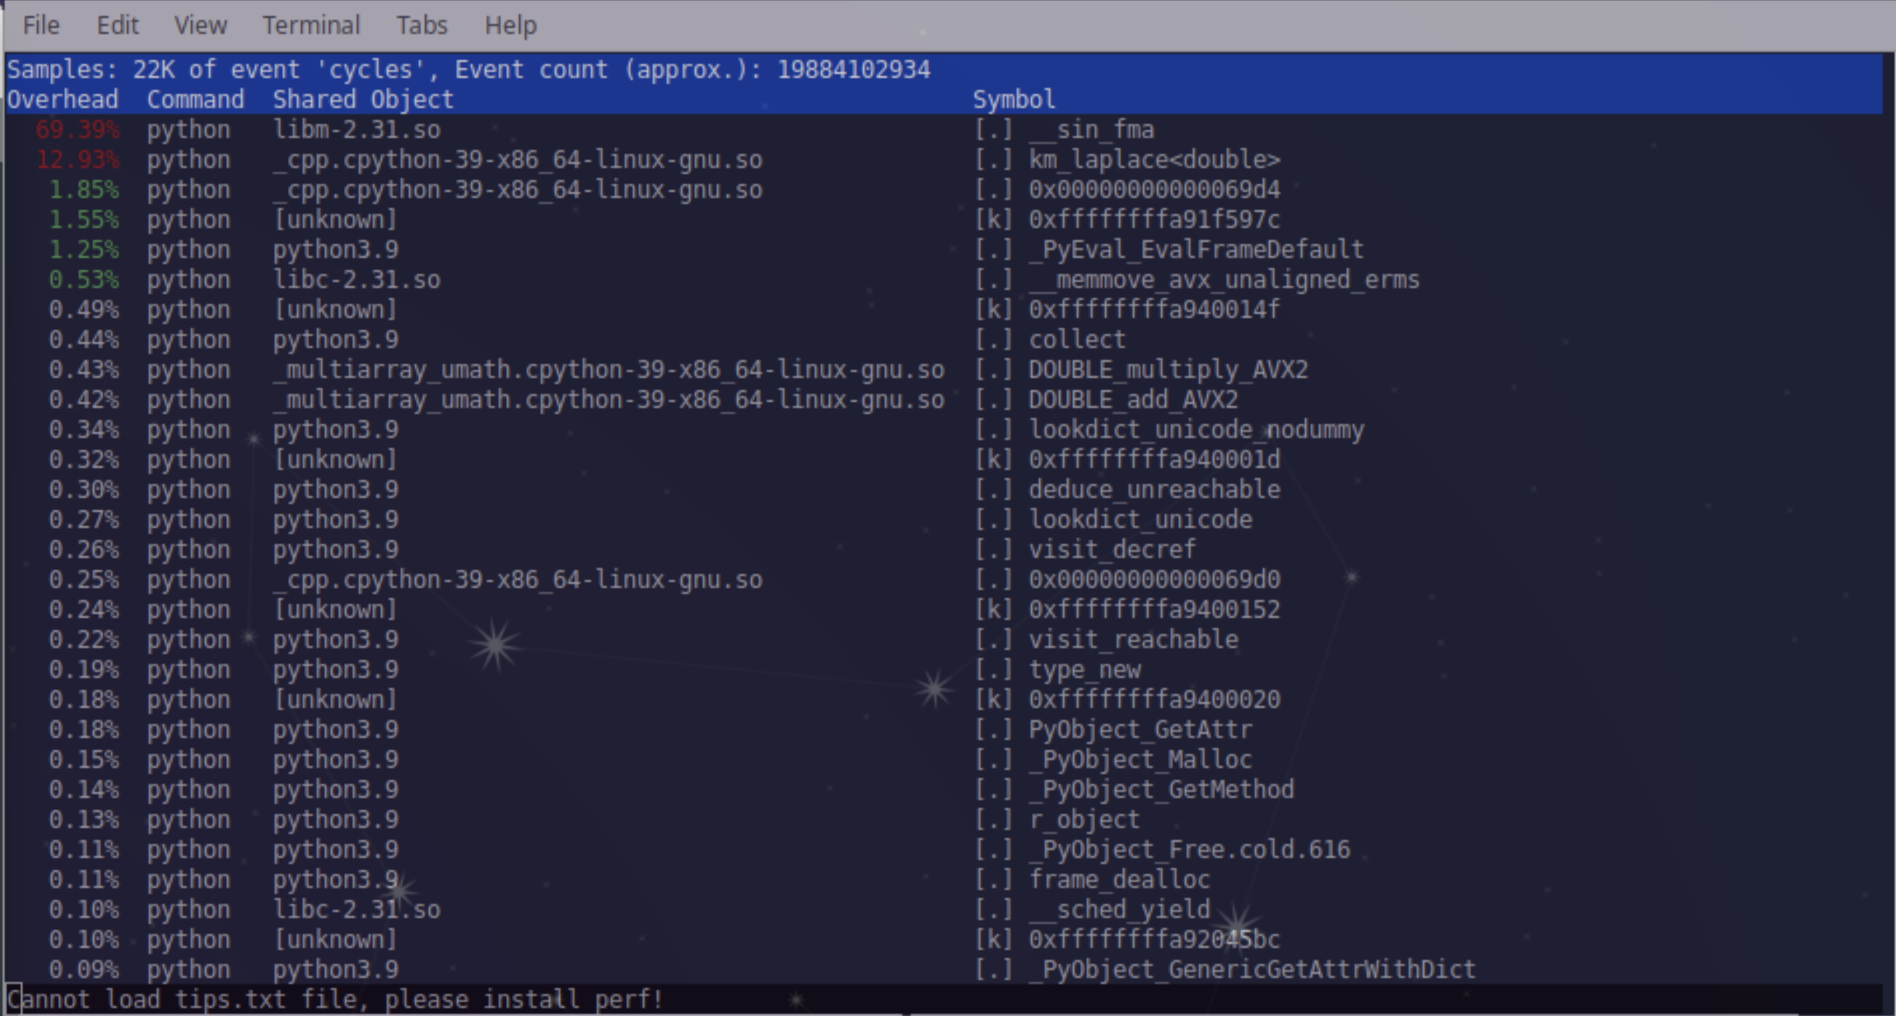

Immediately we will see that calls to the `sin()` functions dominate the runtime. This brings up a numerical question -- can we [approximate the sin function](https://stackoverflow.com/questions/18662261/fastest-implementation-of-sine-cosine-and-square-root-in-c-doesnt-need-to-b) faster? It depends on the use-case. In our case, the non-linearity is fundamental to the problem; if we instead approximate $\sin(x) \approx x$ (which is valid as $x \to 0$) then we get the very different _diffusion_ problem:

$$
\partial_t\theta = \omega + K \nabla \cdot \nabla \theta = \omega + K \Delta \theta
$$

Just for fun, let's use the result of `perf` to replace $\sin(x)$ with $x$ to see how the performance changes:

In [16]:
bench = perfplot.bench(
    setup = lambda T: T,
    n_range = np.logspace(1, 3, 10).astype(int),
    kernels = [
        lambda T: NumpySolver(N=100, T=T, K=2.0).integrate(),
        lambda T: km.CppSolver(N=100, T=T, K=2.0).integrate(),
         lambda T: km.ApproximateCppSolver(N=100, T=T, K=2.0).integrate(),
    ],
    xlabel = 'T',
    labels = ['NumPy', 'C++', 'C++ (Approximate)'],
    equality_check = None
)
bench

Output()

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ NumPy               ┃ C++                  ┃ C++ (Approximate)    ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 10   │ 0.07086653600000001 │ 0.060141819000000006 │ 0.004331607          │
│ 16   │ 0.11016231600000001 │ 0.092594384          │ 0.006700393000000001 │
│ 27   │ 0.17855219          │ 0.152164927          │ 0.011414573          │
│ 46   │ 0.30765754500000003 │ 0.26134708700000003  │ 0.018963226          │
│ 77   │ 0.500408498         │ 0.42484092100000004  │ 0.032693918          │
│ 129  │ 0.822035073         │ 0.6958207580000001   │ 0.056271631          │
│ 215  │ 1.434472996         │ 1.2071186            │ 0.095027818          │
│ 359  │ 2.3207331090000003  │ 1.9379484320000002   │ 0.15812345800000002  │
│ 599  │ 3.8997852820000003  │ 3.2373187540000004   │ 0.27849417000000004  │
│ 1000 │ 6.475385835         │ 5.434442364000001    │ 0.444556137          │
└──────┴─────────────────────┴──────────────────────┴──────────────────────┘

The results are pretty dramatic, and the lesson is that some of the best optimizations are done mathematically. (For example, if we can take a change of coordinates in which the system becomes linear).

## Optimization 2: Floating-point precision

Now we'll make a rather simple optimization: what if we don't need 64-bit precision?

One of the gotchas with using NumPy is that, unless you're very careful, it's easy to "accidentally" up-cast your data from `float32` to `float64`. (This is one of the reasons that major ML frameworks like PyTorch, TensorFlow, etc. don't simply re-use the NumPy library for their CPU implementations). 

In our C++ code, we declared a polymorphic function using templates:
```c++
template <typename T>
void km_laplace(
  py::array_t<T> X,
  py::array_t<T> Y,
  float K
  )
```
Therefore we simply need to initialize our state with the correct precision in NumPy (see [src/kuramoto/base.py](src/kuramoto/base.py)):
```python
self.initial_state = np.random.uniform(0, 2*np.pi, size=(self.N, self.N)).astype(self.dtype)
```
Now we'll run the benchmarks:

In [18]:
bench = perfplot.bench(
    setup = lambda T: T,
    n_range = np.logspace(1, 3, 10).astype(int),
    kernels = [
        lambda T: NumpySolver(N=100, T=T, K=2.0).integrate(),
        lambda T: km.CppSolver(N=100, T=T, K=2.0).integrate(),
         lambda T: km.CppSolver(N=100, T=T, K=2.0, dtype=np.float32).integrate(),
    ],
    xlabel = 'T',
    labels = ['NumPy', 'C++', 'C++ (float32)'],
    equality_check = None
)
bench

Output()

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ NumPy               ┃ C++                 ┃ C++ (float32)       ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 10   │ 0.070055923         │ 0.06021971500000001 │ 0.029139363         │
│ 16   │ 0.11259007900000001 │ 0.09720183800000001 │ 0.044808872         │
│ 27   │ 0.186881021         │ 0.159628077         │ 0.075838113         │
│ 46   │ 0.3127764           │ 0.268736602         │ 0.13318385300000002 │
│ 77   │ 0.518252775         │ 0.441583971         │ 0.22192309000000002 │
│ 129  │ 0.8619647650000001  │ 0.7278333260000001  │ 0.36648313600000004 │
│ 215  │ 1.405806487         │ 1.187426968         │ 0.6190240330000001  │
│ 359  │ 2.400009965         │ 2.0954296350000003  │ 1.043643702         │
│ 599  │ 3.996726064         │ 3.2299149280000004  │ 1.721135155         │
│ 1000 │ 6.496917419000001   │ 5.468067776000001   │ 2.848671549         │
└──────┴─────────────────────┴─────────────────────┴─────────────────────┘

A moderate improvement, but certainly noticeable at large scales.

## Optimization 3: Multithreading

Lastly, we arrive at the most "fun" optimization, and one that cannot be done by NumPy or within Python: **multi-threading**. 

If you've used Python long enough, you've heard of the [Global Interpreter Lock](https://wiki.python.org/moin/GlobalInterpreterLock). This is a [mutex](https://www.geeksforgeeks.org/mutex-lock-for-linux-thread-synchronization/) which prevents access to any Python object by more than one thread at a time. 

By breaking out to C++, we are no longer operating on Python objects (only on the C data structures underlying them, as specified in the C API), and thus we are free to open multiple threads to operate on a NumPy array without fear of the dreaded GIL.

Here, we will use [OpenMP](https://www.openmp.org/), a library and set of compiler directives for C/C++ which enable [shared-memory parallelism](https://en.wikipedia.org/wiki/Parallel_programming_model#Shared_memory). This is in contrast to other tools you may have used in cluster (or _multi-node_) environments such as [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface), which enables multi-process applications by using explicit message passing. In OpenMP, all threads will have access to any data which we _share_ among them, and any other data will be _copied_ or _private_. Let's see how this works:

```c++
#include <omp.h>

...
    
template <typename T>
void km_laplace_parallel(
  py::array_t<T> X,
  py::array_t<T> Y,
  float K
  )
// Parallel Kuramoto Laplacian 
{
  auto X_data = X.template unchecked<2>(); 
  auto Y_data = Y.template mutable_unchecked<2>(); 
  const int m = X.shape(0);
  const int n = X.shape(1);

  #pragma omp parallel for collapse(2) shared(X_data, Y_data, m, n)
  for (int i = 0; i < m; i++) {
    for (int j = 0; j < n; j++) {
      auto x = X_data(i, j);

      if (i > 0) Y_data(i, j) += K * sin(X_data(i-1, j) - x);
      if (j > 0) Y_data(i, j) += K * sin(X_data(i, j-1) - x);
      if (i < m-1) Y_data(i, j) += K * sin(X_data(i+1, j) - x);
      if (j < n-1) Y_data(i, j) += K * sin(X_data(i, j+1) - x);
    }
  }
}
```

In [cpp/operators.cpp](cpp/operators.cpp), you'll find the above definition for `km_laplace_parallel`. Using OpenMP is surprisingly simple. First, you'll need the OpenMP headers, which you can install e.g. on Ubuntu using 
```bash
sudo apt-get install libomp-dev
```
On Mac, unfortunately, OpenMP is not supported out-of-the-box because the [Apple Clang](https://opensource.apple.com/source/clang/clang-23/clang/tools/clang/docs/UsersManual.html) compiler disables OpenMP support. This is also why we run this notebook in Docker. 

Unpacking the above, the main and only difference from our previous C++ code is this pragma:
```c++
...
    #pragma omp parallel for collapse(2) shared(X_data, Y_data, m, n)
...
```
* `#pragma omp parallel for` is a compiler directive telling `gcc` to automatically parallelize the following for-loop; if your system doesn't have OpenMP, this will simply be ignored and your program will run in serial. 
* Next, `collapse(2)` says there are two nested for loops, and we'd like to parallelize them both. 
* Finally, `shared(X_data, Y_data, m, n)` declares that the variables `X_data, Y_data, m, n` must be shared across threads (this is necessary to store the results computed by each thread). 

That's it! You can more about OpenMP pragmas [here](https://www.openmp.org/wp-content/uploads/omp-hands-on-SC08.pdf).


Finally let's benchmark our program. Your performance will vary depending on the number of physical cores you have, and what other work they're doing (such as running a Chrome browser and jupyter server). On my Thinkpad with 2 cores and 4 threads, we see:

In [20]:
bench = perfplot.bench(
    setup = lambda T: T,
    n_range = np.logspace(1, 3, 10).astype(int),
    kernels = [
        lambda T: NumpySolver(N=100, T=T, K=2.0).integrate(),
        lambda T: km.CppSolver(N=100, T=T, K=2.0).integrate(),
        lambda T: km.ParallelCppSolver(N=100, T=T, K=2.0).integrate(),
    ],
    xlabel = 'T',
    labels = ['NumPy', 'C++', 'C++ (OpenMP)'],
    equality_check = None
)
bench

Output()

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ NumPy               ┃ C++                 ┃ C++ (OpenMP)        ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 10   │ 0.07222010400000001 │ 0.062612728         │ 0.028162174         │
│ 16   │ 0.114900677         │ 0.09735291400000001 │ 0.042832618         │
│ 27   │ 0.18380621400000002 │ 0.16061488000000002 │ 0.07338643          │
│ 46   │ 0.31400441700000004 │ 0.263809821         │ 0.137620654         │
│ 77   │ 0.521157893         │ 0.43166795500000005 │ 0.23442024600000003 │
│ 129  │ 0.8408792270000001  │ 0.7032517660000001  │ 0.400003792         │
│ 215  │ 1.406836685         │ 1.170835802         │ 0.6509469           │
│ 359  │ 2.314015564         │ 1.9234021860000001  │ 1.098779761         │
│ 599  │ 3.8883694500000003  │ 3.2234017820000003  │ 1.818755922         │
│ 1000 │ 6.466532826000001   │ 5.356450026         │ 3.1089954680000003  │
└──────┴─────────────────────┴─────────────────────┴─────────────────────┘